# The Numerical Sandbox: Extension Experiment

**Romain Beucher**
Version 0.1

romain.beucher@unimelb.edu.au

The following notebook is an implementation of the Numerical Sandbox Extension Experiment similar to [Buiter et al., 2006](http://sp.lyellcollection.org/content/253/1/29). The test is commonly referred as one of the GEOMOD benchmarks and is used to test the large deformation viscous-plastic behaviour of geodynamic numerical codes.

The initial purpose of the GEOMOD numerical experiments was to compare results from analog and numerical experiments. It is not a numerical benchmark sensus-stricto.

The test has been implemented using Fantom in [Thieulot, 2011](http://linkinghub.elsevier.com/retrieve/pii/S0031920111001336) and more recently with Aspect in [Glerum et al., 2017](http://www.solid-earth-discuss.net/se-2017-9). 

![title](images/underworld.png)

Results for Underworld from this notebook

A | B
- | - 
![title](images/ExtensionA.png) | ![title](images/ExtensionB.png) 

Results for the extension experiment after 2cm extension (Buiter et al., 2006)

In [1]:
import unsupported.geodynamics as GEO
from unsupported import rheology as rheology_library

/Users/jmansour/work/code/uw2_release/unsupported/scaling/__init__.py:13: UserWarning: 

    The scaling module is not supported.

    It requires 'pint' as a dependency.

    You can install pint by running:

    'pip install pint' in a terminal

    Questions should be addressed to romain.beucher@unimelb.edu.au 
 
  Questions should be addressed to romain.beucher@unimelb.edu.au \n """
/Users/jmansour/work/code/uw2_release/unsupported/lithopress/__init__.py:8: UserWarning: 

The lithopress module is not supported.

Questions should be addressed to romain.beucher@unimelb.edu.au 
 
  Questions should be addressed to romain.beucher@unimelb.edu.au \n """
/Users/jmansour/work/code/uw2_release/unsupported/LecodeIsostasy/__init__.py:10: UserWarning: 

    The LecodeIsostasy module is not supported.

    Questions should be addressed to romain.beucher@unimelb.edu.au 
 
  Questions should be addressed to romain.beucher@unimelb.edu.au \n """


In [2]:
u = GEO.UnitRegistry

## Scaling

In [3]:
velocity = 2.5 * u.centimeter / u.hour
model_length = 20. * u.centimeter
bodyforce = 1560 * u.kilogram / u.metre**3 * 9.81 * u.meter / u.second**2

KL = model_length
Kt = KL / velocity
KM = bodyforce * KL**2 * Kt**2

GEO.sca.scaling["[length]"] = KL.to_base_units()
GEO.sca.scaling["[time]"] = Kt.to_base_units()
GEO.sca.scaling["[mass]"]= KM.to_base_units()

# Model Geometry

Set-up of the extension experiment. A viscous layer (PDMS, 10 x 0.5 cm) lies in the central part of the model on the base. The rest of the model consists of three ‘sand’ layers (only differing in colour). Extension is achieved by moving the right wall with the attached 10 cm long sheet outwards to the right.

<img src="images/Extension.png" width=800>

We use a uniform resolution of 0.2 cm (400 x 100 elements)

In [4]:
Model = GEO.Model(elementRes=(200, 50), 
                  minCoord=(0. * u.centimeter, -3.5 * u.centimeter), 
                  maxCoord=(20. * u.centimeter, 1.5 * u.centimeter), 
                  periodic=(False, False), 
                  gravity=(0.0, -9.81 * u.meter / u.second**2))

# Add some Materials

Now that we have our "universe" (box, sand pit) ready, we need to fill it with some materials.
The *geodynamics* module is designed around that idea of materials, which are essentially a way to define physical properties across the Model domain.

A material (or a phase) is first defined by the space it takes in the box (its shape).

In [5]:
minX = Model.minCoord[0]
maxX = Model.maxCoord[0]
minY = Model.minCoord[1]
maxY = Model.maxCoord[1]

In [6]:
air = Model.add_material(name="Air", shape="layer", top=maxY, bottom=0.*u.centimeter)
sand1 = Model.add_material(name="Sand1", shape="layer", top=0.*u.centimeter, bottom=minY)
sand2 = Model.add_material(name="Sand2", shape="layer", top=-1. * u.centimeter, bottom=-2. * u.centimeter)

vertices = [( 5.* u.centimeter, -3.0 * u.centimeter),
            (15.* u.centimeter, -3.0 * u.centimeter),
            (15.* u.centimeter, -3.5 * u.centimeter),
            ( 5.* u.centimeter, -3.5 * u.centimeter)]

silicon = Model.add_material(name="Silicon", vertices=vertices)


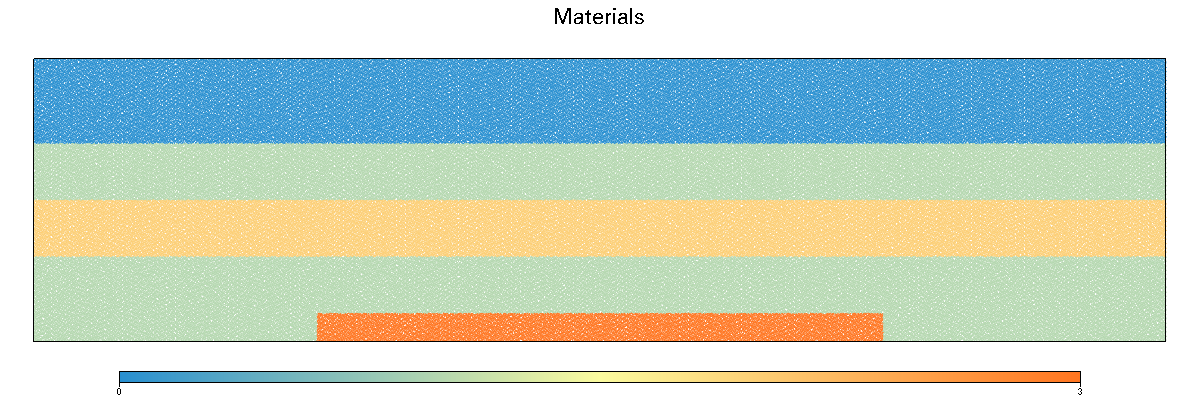

In [7]:
Fig = Model.plot_material()

## Material properties

In [8]:
air.density = 10. * u.kilogram / u.metre**3
sand1.density = 1560. * u.kilogram / u.metre**3
sand2.density = 1560. * u.kilogram / u.metre**3
silicon.density = 965. * u.kilogram / u.metre**3

# Define Viscosities

Viscosities can be defined as a Quantity or a simple scalar value. It is also possible to load predefined rheologies from the rheology_library. 

The rheology library contains some commonly used rheologies stored in a python dictionary structure. We can list the keys defining the rheologies as follows:

In [9]:
ViscousLaws = rheology_library.ViscousLaws # We are just creating an alias.
ViscousLaws.keys()

['Hirth et al., 2003',
 'Tullis et al, 2002',
 'Patterson et al., 1990',
 'Kronenberg et al., 1984',
 'Gleason and Tullis, 1995',
 'Korenaga et al., 2008',
 'Goetze et al., 1978',
 'Brace et al., 1980',
 'Karato and Wu, 1990',
 'Kirby et al., 1987',
 'Koch et al., 1983',
 'Wang et al., 2012',
 'Mackwell et al., 1998',
 'Ribacki et al., 2000']

In [10]:
# Assign function to materials
air.viscosity     = 1.0e2  * u.pascal * u.second
sand1.viscosity   = 1.0e13 * u.pascal * u.second
sand2.viscosity   = 1.0e13 * u.pascal * u.second
silicon.viscosity = 5.0e4  * u.pascal * u.second

# Define Plasticity

Plastic behavior is assigned using the same approach as for viscosities.

In [11]:
Plasticity = rheology_library.PlasticBehaviours
Plasticity.keys()

['Rey et al., 2010 (UpperCrust)',
 'Huismans and Beaumont, 2007 (WeakCrust)',
 'Rey et al., 2010 (LowerCrust)',
 'Rey et al., 2010 (Mantle)']

In [12]:
sandPlasticity = {'coefficients': {'Cohesion': 10. * u.pascal,
  'CohesionSw': 10. * u.pascal,
  'FrictionCoef': 0.73,
  'FrictionCoefSw': 0.60,
  'MinimumViscosity': 1.0e2  * u.pascal * u.second}}

In [13]:
sand1.plasticity = sandPlasticity
sand2.plasticity = sandPlasticity

# Boundary conditions

+ Basal points above the moving sheet are assigned the velocity of the sheet
+ Basal points to the left of the moving sheet are held fixed. 
+ The change in velocity at the basal velocity discontinuity is accommodated over 0.2 cm. 
+ The vertical sides are fixed.

In [14]:
Model.set_velocityBCs(left=[0 * u.centimeter / u.hour, None],
                      right=[2.5 * u.centimeter / u.hour, None],
                      bottom=[0.0, 0.0])

In [15]:
base = Model.mesh.specialSets["MinJ_VertexSet"]
   
nd = GEO.sca.nonDimensionalize

for node in base:
    x, y = Model.mesh.data[node]
    if x > nd(10.1 * u.centimetre):
        Model.velocity.data[node,0] = nd(velocity)
    elif x > nd(9.9 * u.centimetre):
        Model.velocity.data[node,0] = (x - nd(9.9 * u.centimetre)) * nd(velocity) / nd(0.2 * u.centimetre)

## Initialise Model

The model is initialize using the *init_model* method which will solve the initial steady state temperature field and the pressure field.

In [16]:
Model.minViscosity = 1.0e2 * u.pascal * u.second
Model.maxViscosity = 1.0e9 * u.pascal * u.second

In [17]:
Model.init_model()


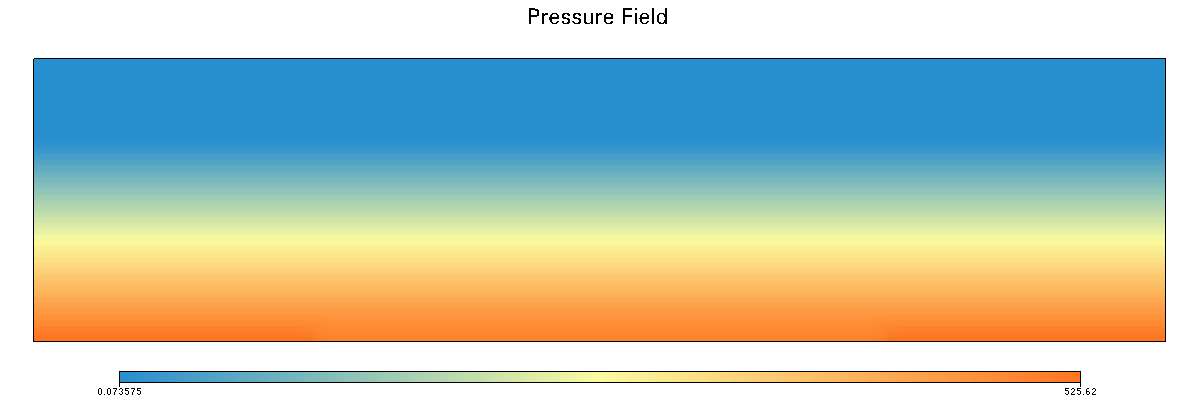

In [18]:
Fig = Model.plot_pressure()


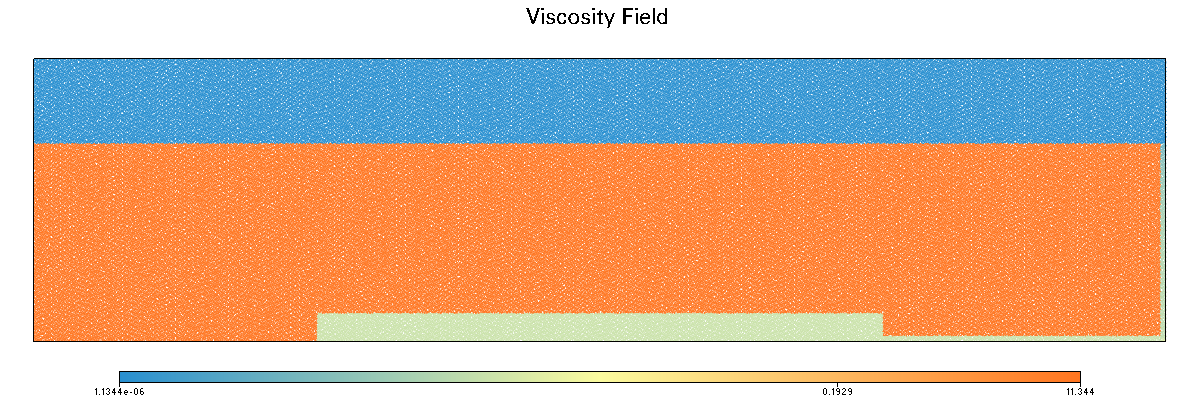

In [19]:
Fig = Model.plot_viscosity()

In [20]:
Model.checkpoint()

In [21]:
Model.run_for(1.0* u.hours, checkpoint=10*u.minutes)

Time:  0.0199521490242 hour
Time:  0.0399099802147 hour
Time:  0.0598705364909 hour
Time:  0.079838673347 hour
Time:  0.0998164234102 hour
Time:  0.119800755594 hour
Time:  0.139788181993 hour
Time:  0.15978274519 hour
Time:  0.166666666667 hour
Time:  0.186663892301 hour
Time:  0.20666052128 hour
Time:  0.226658797024 hour
Time:  0.246655561071 hour
Time:  0.266653337833 hour
Time:  0.286650401573 hour
Time:  0.306647037687 hour
Time:  0.326643428229 hour
Time:  0.333333333333 hour
Time:  0.35333051156 hour
Time:  0.373327163129 hour
Time:  0.393324129078 hour
Time:  0.413320291815 hour
Time:  0.433316330779 hour
Time:  0.453312652779 hour
Time:  0.473308528612 hour
Time:  0.493304444064 hour
Time:  0.5 hour
Time:  0.519979857814 hour
Time:  0.539952293111 hour
Time:  0.559898558548 hour
Time:  0.579834148329 hour
Time:  0.599772018169 hour
Time:  0.619698601372 hour
Time:  0.639634830308 hour
Time:  0.659565325166 hour
Time:  0.666666666667 hour
Time:  0.686626848452 hour
Time:  0.70


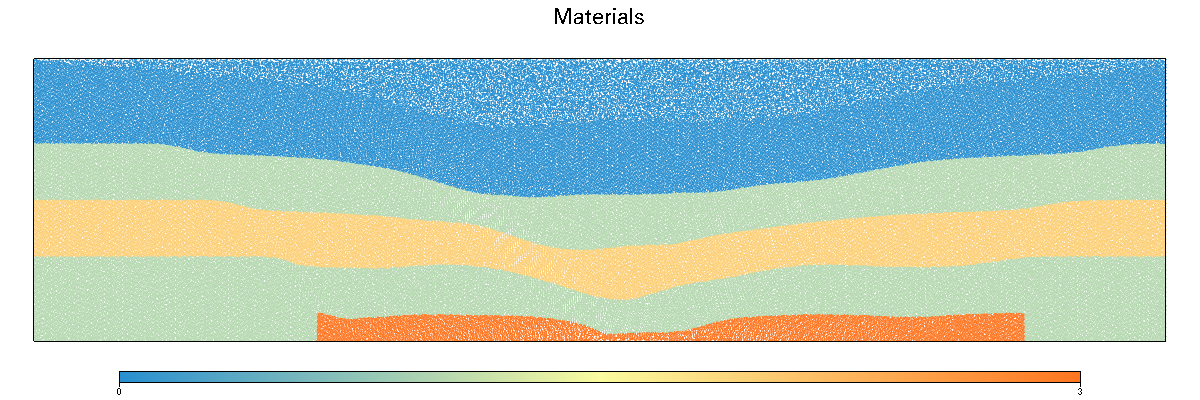

{'antialias': True,
 'axis': False,
 'background': 'white',
 'border': 1,
 'bordercolour': 'black',
 'margin': 34,
 'quality': 1,
 'resolution': (1200, 400),
 'rulers': False,
 'title': 'Materials',
 'zoomstep': 0}

In [22]:
Model.plot_material()